In [18]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

In [19]:
def create_sine_wave(frequency, duration, sample_rate):
    """ Create a sine wave with the given frequency, duration and sample rate """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal = np.sin(2 * np.pi * frequency * t)
    return t, signal

def quantize_signal(signal, bits):
    """ Quantize the signal to the given number of bits """
    levels = 2 ** bits
    quantized_signal = np.round(signal * (levels // 2 - 1)).astype(np.int8)
    return quantized_signal

def simulate_network_latency(signal, packet_size, latencies):
    """ Simulate network latency by delaying packets in the signal """
    packets = [signal[i:i + packet_size] for i in range(0, len(signal), packet_size)]
    delayed_signal = np.zeros_like(signal)
    for i, packet in enumerate(packets):
        start_index = i * packet_size
        delay = latencies[i % len(latencies)]
        delayed_signal[start_index:start_index + packet_size] = np.roll(packet, delay)
    return delayed_signal

def simulate_packet_loss(signal, packet_size, loss_probability):
    """ Simulate packet loss by dropping packets in the signal """
    packets = [signal[i:i + packet_size] for i in range(0, len(signal), packet_size)]
    lost_signal = np.zeros_like(signal)
    for i, packet in enumerate(packets):
        if np.random.rand() > loss_probability:
            start_index = i * packet_size
            lost_signal[start_index:start_index + packet_size] = packet
    return lost_signal

In [20]:
# 1.a. Création d'un signal de référence
frequency = 2000  # 2kHz
duration = 3  # 3 seconds
sample_rate = frequency * 10  # 10 échantillons par période
t, signal = create_sine_wave(frequency, duration, sample_rate)

# Play the sine wave
sd.play(signal, sample_rate)
sd.wait()

In [21]:
# 1.b+c Quantifier ce signal en utilisant différentes résolutions
quantized_signal_8bit = np.round(signal * 127).astype(np.int8)
quantized_signal_6bit = quantize_signal(signal, 6)
quantized_signal_4bit = quantize_signal(signal, 4)
quantized_signal_3bit = quantize_signal(signal, 3)
quantized_signal_2bit = quantize_signal(signal, 2)
quantized_signal_1bit = quantize_signal(signal, 1)

1.d. Que se passe-t-il quand la résolution du quantificateur devient 1 bit/éch ?

2. Quand la résolution du quantificateur devient 1 bit/éch, le signal de sortie est une onde carrée. La fréquence de l'onde carrée est égale à la fréquence du signal d'entrée. La forme d'onde carrée est obtenue en comparant le signal d'entrée avec une onde sinusoïdale de fréquence égale à celle du signal d'entrée.

In [22]:
# 2. Simuler la latence d'un réseau fonctionnant en mode paquet
latencies = [0, 1, 2, 3, 4]  # Différentes latences pour chaque paquet
packet_size = 2  # 2 échantillons par paquet
delayed_signal = simulate_network_latency(quantized_signal_8bit, packet_size, latencies)

In [23]:
# 3. Simuler la perte de paquets
loss_probability_1 = 10**-3
loss_probability_2 = 10**-2
lost_signal_1 = simulate_packet_loss(quantized_signal_8bit, packet_size, loss_probability_1)
lost_signal_2 = simulate_packet_loss(quantized_signal_8bit, packet_size, loss_probability_2)

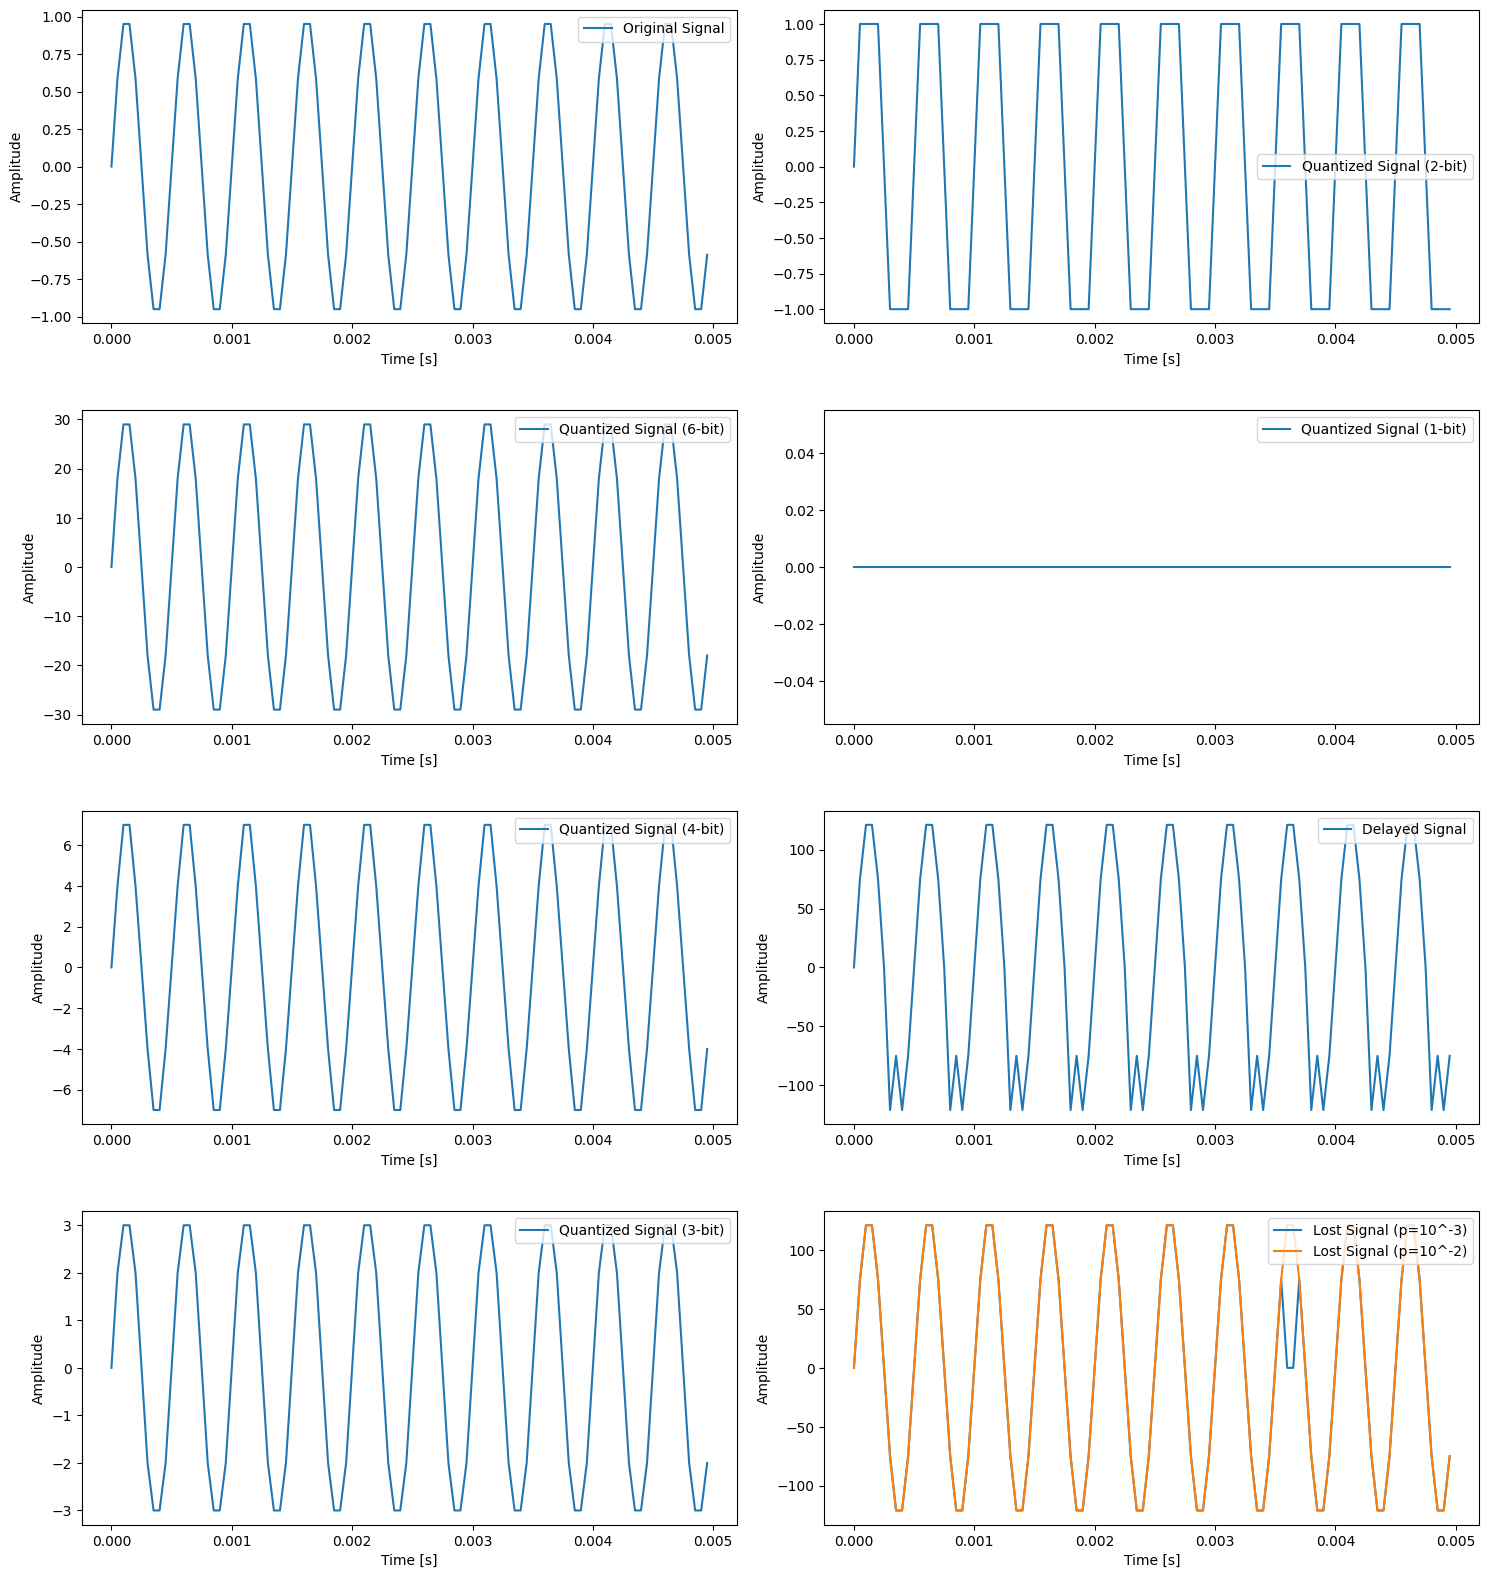

In [24]:
# Plotting the signals
slice_length = 100
t_slice = t[:slice_length]

plt.figure(figsize=(15, 18))

plt.subplot(4, 2, 1)
plt.plot(t_slice, signal[:slice_length], label='Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(t_slice, quantized_signal_6bit[:slice_length], label='Quantized Signal (6-bit)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 5)
plt.plot(t_slice, quantized_signal_4bit[:slice_length], label='Quantized Signal (4-bit)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 7)
plt.plot(t_slice, quantized_signal_3bit[:slice_length], label='Quantized Signal (3-bit)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(t_slice, quantized_signal_2bit[:slice_length], label='Quantized Signal (2-bit)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(t_slice, quantized_signal_1bit[:slice_length], label='Quantized Signal (1-bit)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 6)
plt.plot(t_slice, delayed_signal[:slice_length], label='Delayed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 2, 8)
plt.plot(t_slice, lost_signal_1[:slice_length], label='Lost Signal (p=10^-3)')
plt.plot(t_slice, lost_signal_2[:slice_length], label='Lost Signal (p=10^-2)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout(h_pad=4)
plt.subplots_adjust(bottom=0.15)
plt.show()

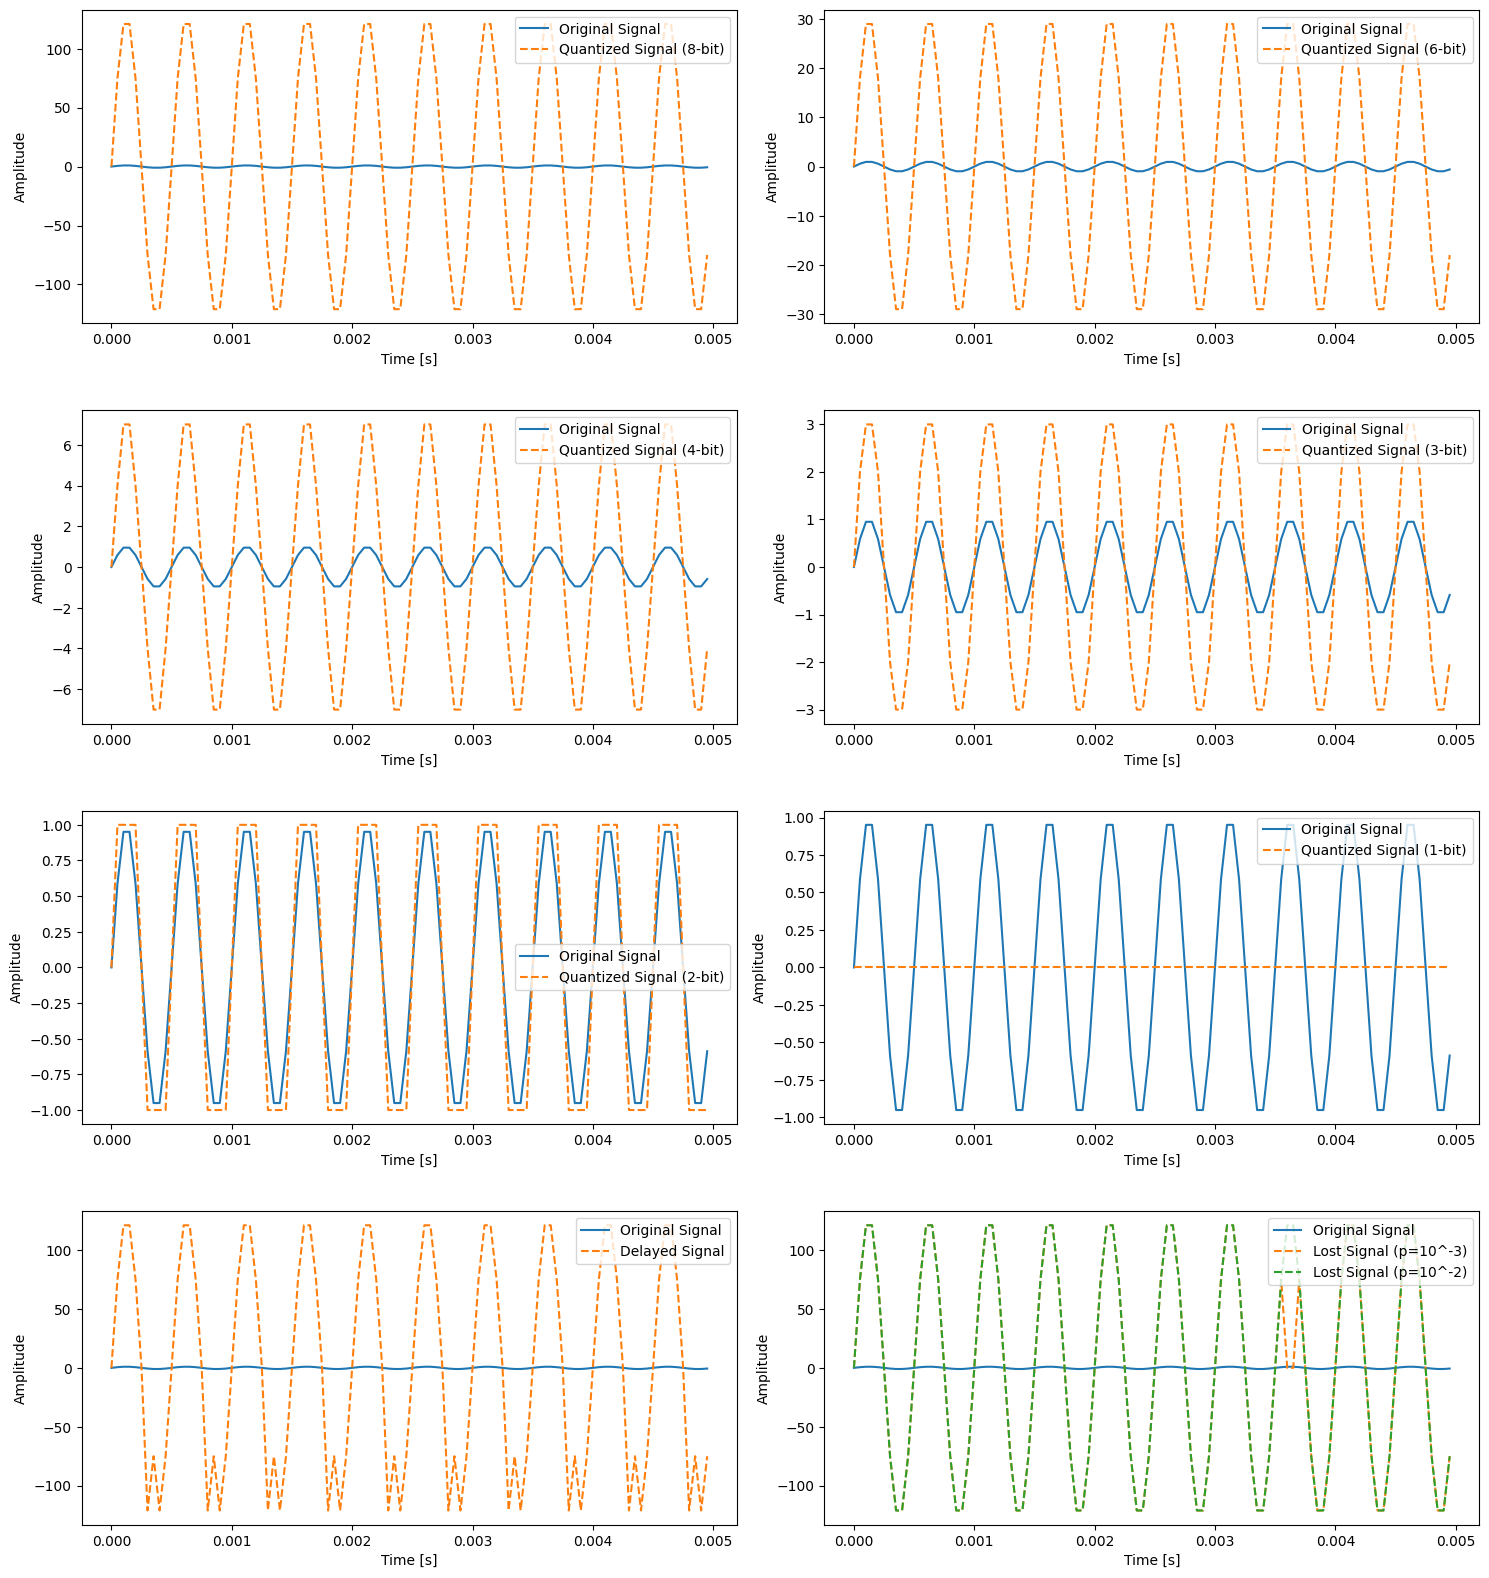

In [25]:
def plot_signal_subplot(position, t_slice, original_signal, quantized_signal, label):
    plt.subplot(4, 2, position)
    plt.plot(t_slice, original_signal, label='Original Signal')
    plt.plot(t_slice, quantized_signal, label=label, linestyle='--')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()

# Overlay Plots and Error Plots
slice_length = 100
t_slice = t[:slice_length]

plt.figure(figsize=(15, 18))

# Overlay plots
plot_signal_subplot(1, t_slice, signal[:slice_length], quantized_signal_8bit[:slice_length], 'Quantized Signal (8-bit)')
plot_signal_subplot(2, t_slice, signal[:slice_length], quantized_signal_6bit[:slice_length], 'Quantized Signal (6-bit)')
plot_signal_subplot(3, t_slice, signal[:slice_length], quantized_signal_4bit[:slice_length], 'Quantized Signal (4-bit)')
plot_signal_subplot(4, t_slice, signal[:slice_length], quantized_signal_3bit[:slice_length], 'Quantized Signal (3-bit)')
plot_signal_subplot(5, t_slice, signal[:slice_length], quantized_signal_2bit[:slice_length], 'Quantized Signal (2-bit)')
plot_signal_subplot(6, t_slice, signal[:slice_length], quantized_signal_1bit[:slice_length], 'Quantized Signal (1-bit)')

# Delayed signal
plt.subplot(4, 2, 7)
plt.plot(t_slice, signal[:slice_length], label='Original Signal')
plt.plot(t_slice, delayed_signal[:slice_length], label='Delayed Signal', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

# Lost signal
plt.subplot(4, 2, 8)
plt.plot(t_slice, signal[:slice_length], label='Original Signal')
plt.plot(t_slice, lost_signal_1[:slice_length], label='Lost Signal (p=10^-3)', linestyle='--')
plt.plot(t_slice, lost_signal_2[:slice_length], label='Lost Signal (p=10^-2)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout(h_pad=4)
plt.subplots_adjust(bottom=0.15)
plt.show()